## Imports

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from model_classes import HealthModel
import torch
from datetime import datetime as dt
import os

## Config

Linear regressor config:

In [246]:
config = {
    "architecture": "linear_regressor",
    "train_size": 0.8,
    "val_size": False, # Set MLP 
    "hidden_layer_sizes": False, # configs
    "batch_size": False, # to False
    "num_epochs": False, # if using
    "learning_rate": False, # linear regressor
    "spatial_resolution": "regional",
    "temporal_resolution": "daily",
    "input_artifacts": ["laqn-regional", "met-resample", "income-regional"],
    "laqn_variables": ["NO2", "PM10"], # Set to False if excluding air pollutants
    "met_variables": ["temperature", "humidity", "dew_point", "wind_speed", "pressure"], # "wind_dir"# Set to False if excluding meteorology
    "income_variables": ["gross_disposable_income", "property_income_received", #"property_income_paid", 
                         "social_benefits_received", "current_taxes_on_wealth"], # Set to False if excluding income
    "ablation_features": False, #["temperature"] # Set to False if not analysing feature importance
    "target_shift": 1, # Time lag end point for target variable
    "window_size": 20 # Input window size
    }

MLP regressor config:

In [16]:
config = {
    "architecture": "MLP_regressor",
    "train_size": 0.7,
    "val_size": 0.15, # Set MLP configs
    "hidden_layer_size": 10,
    "num_layers": 1,
    "batch_size": 30, # to False
    "num_epochs": 100, # if using
    "learning_rate": 0.001, # linear regressor
    "spatial_resolution": "regional",
    "temporal_resolution": "daily",
    "input_artifacts": ["laqn-regional", "met-resample", "income-regional"],
    "laqn_variables": ["NO2", "PM10"], # Set to False if excluding air pollutants
    "met_variables": ["temperature", "humidity", "dew_point", "wind_speed", "pressure"], # "wind_dir" # Set to False if excluding meteorology
    "income_variables": ["gross_disposable_income", "property_income_received", "social_benefits_received", "current_taxes_on_wealth"], # Set to False if excluding income
    "ablation_features": ["PM10"], # Set to False if not analysing feature importance
    "target_shift": 1, # Time lag for target variable
    "window_size": 1 # Input window size
    }

torch.manual_seed(1)

LSTM regressor config:

In [325]:
config = {
    "architecture": "LSTM_regressor",
    "train_size": 0.7,
    "val_size": 0.15, 
    "hidden_layer_size": 10,
    "num_layers": 1,
    "batch_size": 30, 
    "num_epochs": 100, 
    "learning_rate": 0.001, 
    "spatial_resolution": "regional",
    "temporal_resolution": "daily",
    "input_artifacts": ["laqn-regional", "met-resample", "income-regional"],
    "laqn_variables": ["NO2", "PM10"], # Set to False if excluding air pollutants
    "met_variables": ["temperature", "humidity", "dew_point", "wind_speed", "pressure"], # "wind_dir" # Set to False if excluding meteorology
    "income_variables": ["gross_disposable_income", "property_income_received", "social_benefits_received", "current_taxes_on_wealth"], # Set to False if excluding income
    "ablation_features": ["gross_disposable_income", "property_income_received", "social_benefits_received", "current_taxes_on_wealth"], # Set to False if not analysing feature importance
    "target_shift": 1, # Time lag for target variable
    "window_size": 14 # Input window size
    }

torch.manual_seed(1)

In [23]:
if not config["ablation_features"]:
    plot_title_model = f"(all inputs, time lag {config['target_shift']} window {config['window_size']})"
else:
    plot_title_model = f"(scrambled {', '.join(config['ablation_features'])}, time lag {config['target_shift']} window {config['window_size']})"

## Code

In [17]:
model = HealthModel(config)

In [18]:
inputs, targets, datetime = model.preprocess_and_log()

laqn-regional


wandb:   6 of 6 files downloaded.  


met-resample


wandb:   8 of 8 files downloaded.  


income-regional


wandb:   51 of 51 files downloaded.  


input columns:  Index(['NO2_mean', 'NO2_min', 'NO2_max', 'PM10_mean', 'PM10_max', 'PM10_min',
       'temperature_mean', 'temperature_min', 'temperature_max',
       'humidity_mean', 'humidity_min', 'humidity_max', 'dew_point_mean',
       'dew_point_min', 'dew_point_max', 'wind_speed_mean', 'wind_speed_min',
       'wind_speed_max', 'pressure_mean', 'pressure_min', 'pressure_max',
       'gross_disposable_income_min', 'gross_disposable_income_median',
       'gross_disposable_income_max', 'property_income_received_max',
       'property_income_received_median', 'property_income_received_min',
       'social_benefits_received_median', 'social_benefits_received_max',
       'social_benefits_received_min', 'current_taxes_on_wealth_median',
       'current_taxes_on_wealth_max', 'current_taxes_on_wealth_min'],
      dtype='object')
Ablation - scrambled columns: ['PM10_mean', 'PM10_max', 'PM10_min']


wandb:   1 of 1 files downloaded.  



 train
inputs (5363, 33)
targets (5363,)
datetime index (5363,)
Processing time lagged (1) input windows (length 1)
inputs (before flattening) (5362, 1, 33)
targets (before flattening) (5362, 1)
datetime index (5362,)

 val
inputs (1149, 33)
targets (1149,)
datetime index (1149,)
Processing time lagged (1) input windows (length 1)
inputs (before flattening) (1148, 1, 33)
targets (before flattening) (1148, 1)
datetime index (1148,)

 test
inputs (1150, 33)
targets (1150,)
datetime index (1150,)
Processing time lagged (1) input windows (length 1)
inputs (before flattening) (1149, 1, 33)
targets (before flattening) (1149, 1)
datetime index (1149,)


In [6]:
# print("window_size: ", config["window_size"])
# model.create_baseline()

In [7]:
# model.train_and_log()

MLP-regressor


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


x_train shape (5362, 1, 33)
hidden layer sizes [33, 10]


100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


best_epoch,▁
best_mean_absolute_percentage_error_train,▁
best_mean_absolute_percentage_error_val,▁
best_mean_squared_error_train,▁
best_mean_squared_error_val,▁
best_r_squared_train,▁
best_r_squared_val,▁
best_rmse_train,▁
best_rmse_val,▁
best_smape_train,▁
best_smape_val,▁


In [19]:
print(config["architecture"])
print("window_size: ", config["window_size"])
data_dict = model.test_and_log()

MLP_regressor
window_size:  1


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


mean_absolute_percentage_error_test,▁
mean_squared_error_test,▁
r2_test,▁
rmse_test,▁
smape_test,▁
mean_absolute_percentage_error_test,11.85448
mean_squared_error_test,0.04704
r2_test,0.18124
rmse_test,0.21688
smape_test,11.2546


#### Alternative
If the model has already been run, lookup the test_and_log output artifact version on the wandb web interface and read it in here:

In [20]:
#data_dict = model.read_data("xy_all", "v2") 

## Plot results

In [24]:
df = pd.DataFrame()
subsets = ["train", "val", "test"] if config["val_size"] else ["train", "test"]
for subset in subsets:
    subset_df = pd.DataFrame(index=pd.DatetimeIndex(data_dict[f"{subset}_dates"]), data={"observed":data_dict[f"y_{subset}"].flatten(), "predicted":data_dict[f"y_{subset}_predict"].flatten()})
    df = subset_df.copy() if df.empty else df.append(subset_df)

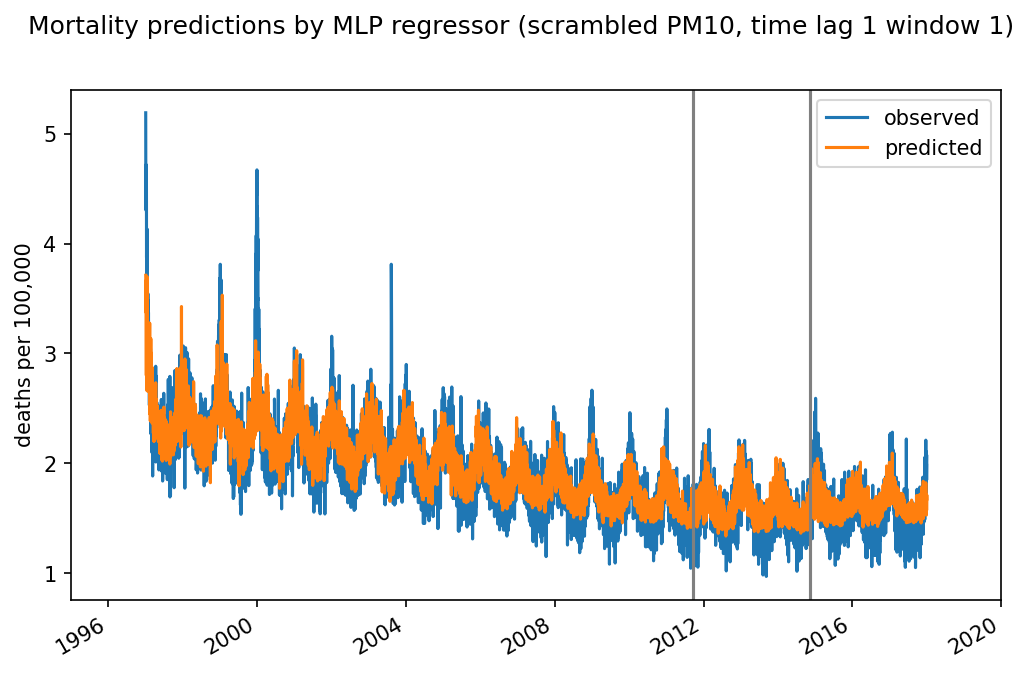

In [25]:
plt.figure(figsize=(8,5), dpi=150)
df["observed"].plot()
df["predicted"].plot()
plt.axvline(data_dict["train_dates"].max(), color="grey")
plt.axvline(data_dict["val_dates"].max(), color="grey") if config["val_size"] else None
plt.legend()
plt.ylabel("deaths per 100,000")
plt.xlim(dt(year=1995, month=1, day=1), dt(year=2020, month=1, day=1))
regressor_title = config["architecture"].replace("_", " ")
plt.suptitle(f"Mortality predictions by {regressor_title} {plot_title_model}")
plt.show()

## Visualisation of ablation results

In [54]:
import json        

# Define the categories for the ablation features
def categorise_feature(features):
    # Define feature categories
    pollution_features = set(["NO2", "PM10"])
    meteorological_features = set(["temperature", "humidity", "dew_point", "wind_speed", "pressure"])
    environmental_features = set(["NO2", "PM10", "temperature", "humidity", "dew_point", "wind_speed", "pressure"])
    socioeconomic_features = set(["gross_disposable_income", "property_income_received", "social_benefits_received", "current_taxes_on_wealth"])
    
    # Convert the JSON string to a Python list
    features = json.loads(features)
    feature_set = set(features)
    
    # Categorize based on feature sets
    if feature_set == pollution_features:
        return "ALL pollution"
    elif feature_set == meteorological_features:
        return "ALL meteorology"
    elif feature_set == environmental_features:
        return "ALL environmental"
    elif feature_set == socioeconomic_features:
        return "ALL socioeconomics"
    else:
        return features[0].replace("_", " ")

In [55]:
window_size = 56
# top = 5
sort_by = "MLP"

In [68]:
ablation_df = pd.read_csv(f"regional_ablation_results/window_size_{window_size}.csv")
df = ablation_df[["architecture", "window_size", "ablation_features", "random_seed", "smape_test"]]

In [69]:
# Filter baseline values (where 'ablation_features' is 'false') for each architecture and random seed
baseline_df = df[df['ablation_features'] == 'false'].set_index(['architecture', 'random_seed'])['smape_test']

# Exclude the baseline rows from the main DataFrame
df = df[df['ablation_features'] != 'false']

# Calculate the difference from the baseline for each random seed
df['smape_diff'] = df.apply(
    lambda row: row['smape_test'] - baseline_df.loc[(row['architecture'], row['random_seed'])],
    axis=1
)

# Aggregate to calculate mean and standard deviation for each ablation feature and architecture
agg_df = df.groupby(['ablation_features', 'architecture'])['smape_diff'].agg(['mean', 'std']).reset_index()

# Pivot the DataFrame to create separate columns for each architecture's mean and std
pivot_mean = agg_df.pivot(index='ablation_features', columns='architecture', values='mean')
pivot_std = agg_df.pivot(index='ablation_features', columns='architecture', values='std')

# Combine the mean and standard deviation tables
pivot_df = pivot_mean.add_suffix('_mean').join(pivot_std.add_suffix('_std'))

# Reset index to make 'ablation_features' a column again
df = pivot_df.reset_index()

# Apply categorisation to the 'ablation_features' column
df['feature_category'] = df['ablation_features'].apply(categorise_feature)

# Optionally sort by the mean value of a specific architecture
sort_by = 'LSTM'  # Example: use 'LSTM' or 'MLP' to specify the architecture to sort by
df = df.sort_values(by=f'{sort_by}_regressor_mean', ascending=True)



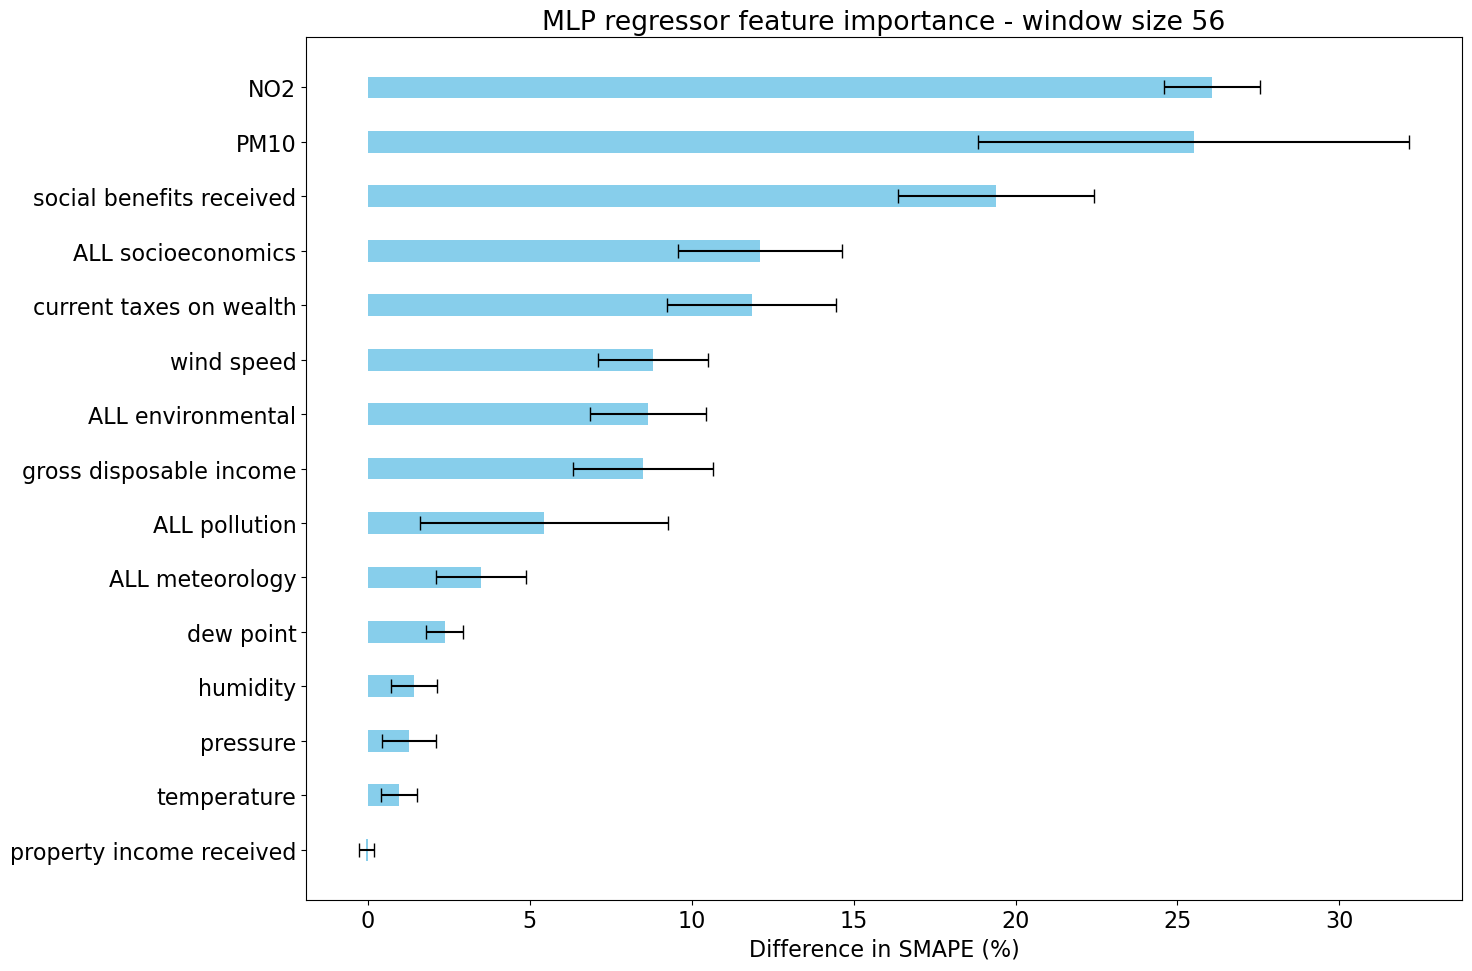

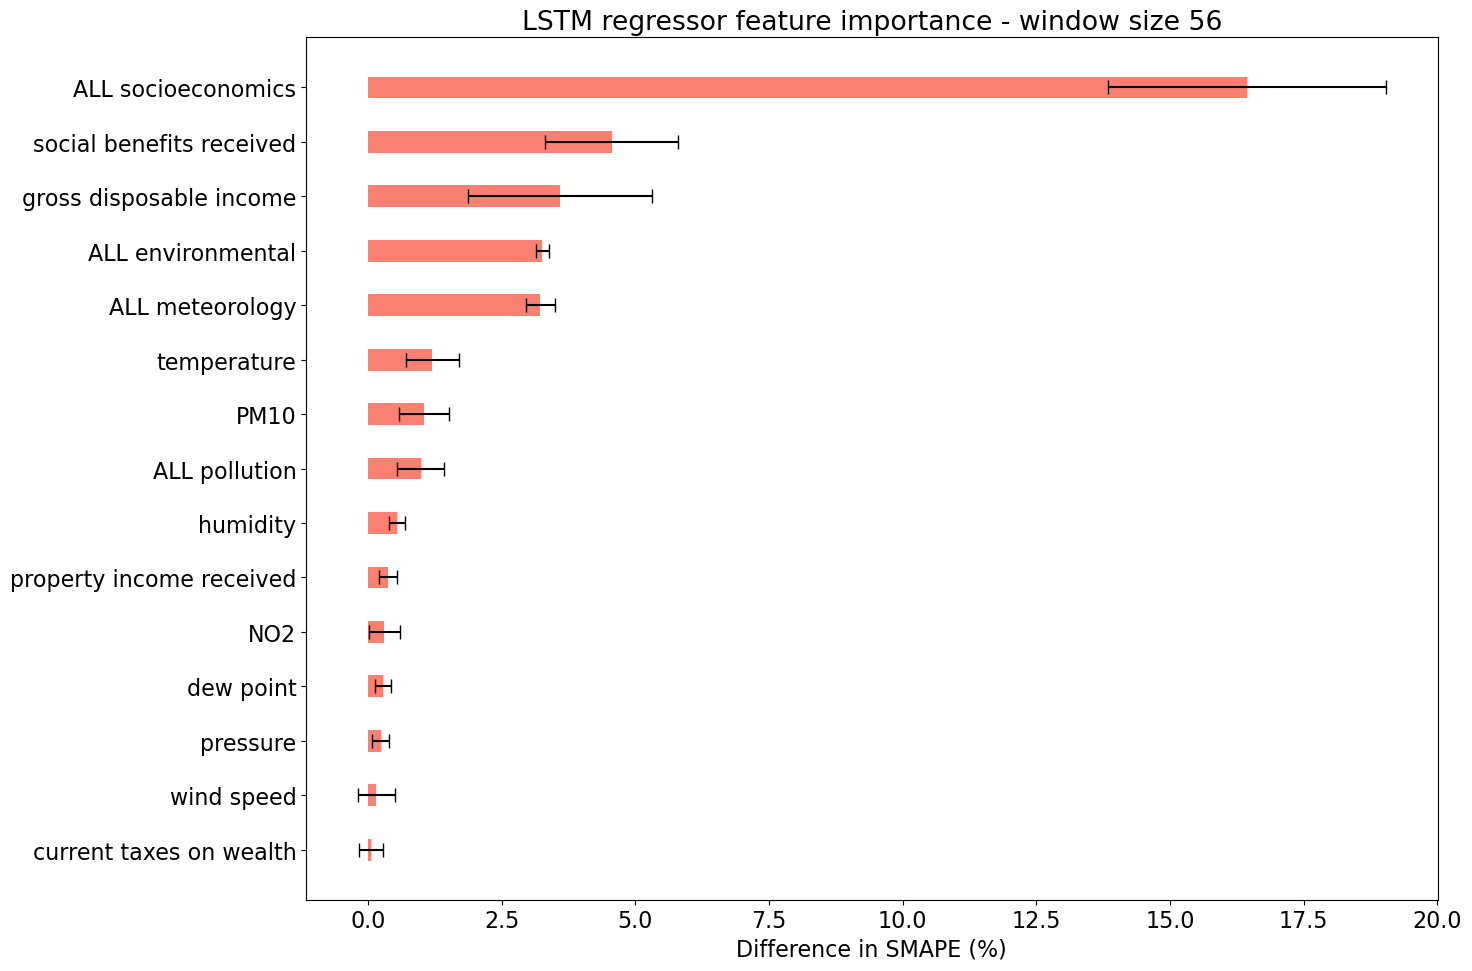

In [71]:
# Ensure the output directory exists
output_dir = f"figures/window_{window_size}"
os.makedirs(output_dir, exist_ok=True)

# Colours for the regressors
colour_dict = {"MLP": "skyblue", "LSTM": "salmon"}

# Bar width for the grouped bars
bar_width = 0.4
index = range(len(df))

for sort_by in ["MLP", "LSTM"]:
    # Sort DataFrame based on the mean values for the current regressor
    df = df.sort_values(by=f'{sort_by}_regressor_mean', ascending=True)
    
    plt.figure(figsize=(15, 10))
    
    # Plot bars with error bars for standard deviation
    plt.barh(
        [i for i in index],  # Y positions
        df[f'{sort_by}_regressor_mean'],  # Bar heights (means)
        bar_width,  # Width of bars
        label=f'{sort_by} regressor',  # Legend label
        color=colour_dict[sort_by],  # Bar colour
        xerr=df[f'{sort_by}_regressor_std'],  # Error bars (standard deviations)
        capsize=5  # Error bar cap size
    )
    
    # Adding labels and title
    plt.yticks(index, df['feature_category'])  # Feature names on Y-axis
    plt.xlabel('Difference in SMAPE (%)')  # X-axis label
    plt.title(f'{sort_by} regressor feature importance - window size {window_size}')  # Plot title
    plt.tight_layout()  # Adjust layout for readability
    
    # Save the plot
    filename = f"{sort_by}_features.png"
    plt.savefig(os.path.join(output_dir, filename))
    
    # Display the plot
    plt.show()


# Visualisation of window length sweeps

In [39]:
from scipy.signal import savgol_filter

models = {
    "MLP": "sweep_vsumpyeb-MLP_window_sizes",
    "LSTM": "sweep_yz4gmnjx-LSTM_window_sizes"
}

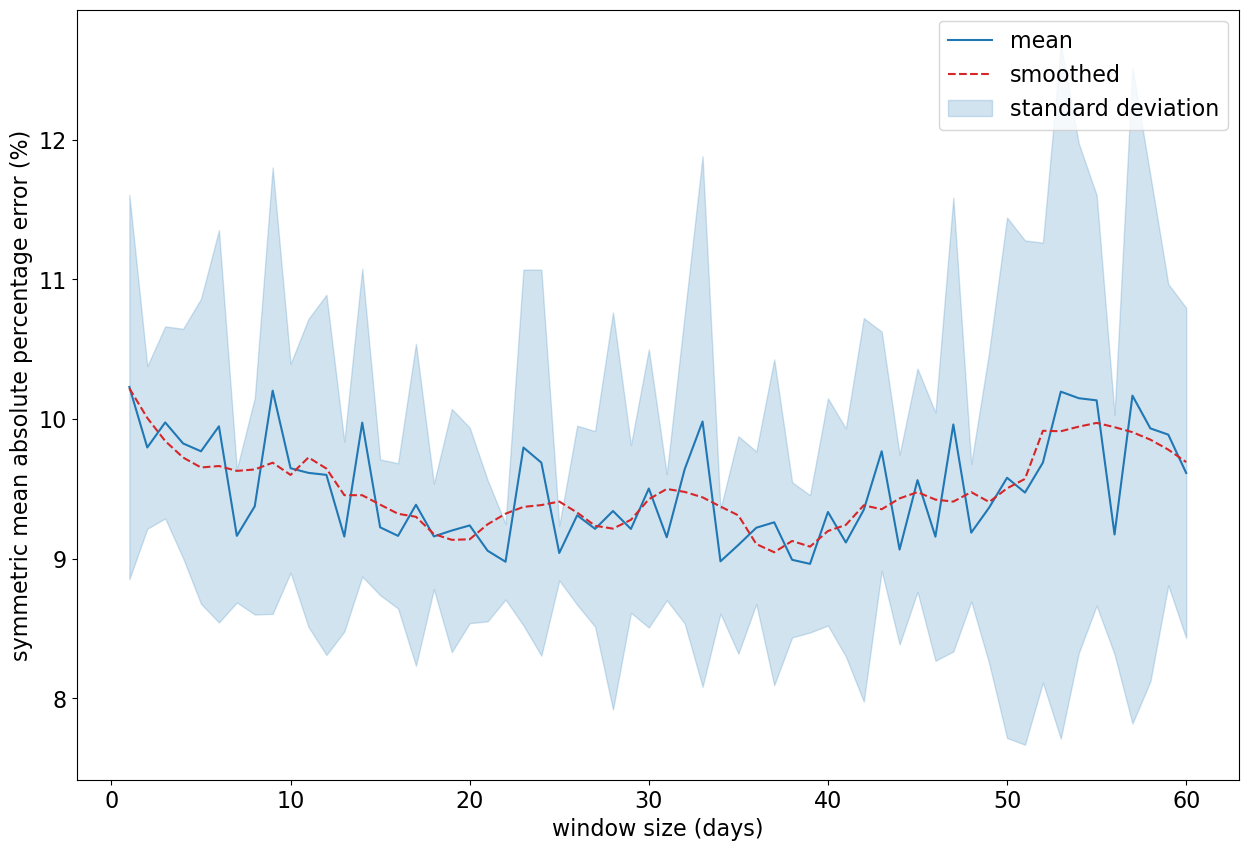

In [47]:
model = "MLP"

df = pd.read_csv(f"results/{models[model]}.csv")
grouped = df.groupby("window_size")["smape_test"].agg(["mean", "std"]).reset_index()
smoothed_mean = savgol_filter(grouped['mean'], window_length=9, polyorder=2)  # Adjust window_length for more/less smoothing

plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(15, 10))
plt.plot(grouped['window_size'], grouped['mean'], label="mean", color="tab:blue")
plt.plot(grouped['window_size'], smoothed_mean, label='smoothed', color='tab:red', linestyle='--')
plt.fill_between(
    grouped['window_size'], 
    grouped['mean'] - grouped['std'], 
    grouped['mean'] + grouped['std'],
    color='tab:blue',
    alpha=0.2,
    label='standard deviation'
)
plt.xlabel('window size (days)')
plt.ylabel('symmetric mean absolute percentage error (%)')
plt.legend()

plt.savefig(f"results/{models[model]}.png")
plt.show()